<div style="background-color:#00b894; padding: 20px; border-radius: 10px; text-align: center;">
  <h2 style="font-size: 30px; color: #ffffff; margin: 0;">⚙️ Model Training & Evaluation - Energy Consumption Forecasting</h2>
</div>

---

<div style="text-align: center;">
<span style="font-size: 20px; color: #393e46;"><strong>"Great models don’t just predict — they uncover hidden rhythms in the chaos of data."</strong></span>  <br>
<span style="color: #6c757d;"><em>– Unknown Visionary</em></span>
</div>

---

<div style="font-weight: 600; line-height: 1.6; font-size: 15px;">

🌟 <span style="font-size:16px; font-weight:600;">With faith in our efforts and blessings from the Almighty,</span>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We now step into the most critical phase of our journey —Model Training & Evaluation.

Now that our dataset has been carefully crafted through thoughtful preprocessing and feature engineering, it's time to <strong>unleash the power of machine learning</strong>.

In this phase, we will:

<ul>
  <li>Split the feature-engineered dataset into train, validation, and test sets (70/15/15)</li>
  <li>Train a robust <strong>XGBoost Regressor</strong> model manually</li>
  <li>Evaluate performance using precise regression metrics</li>
  <li>Visualize and interpret model behavior with detailed plots</li>
  <li>Benchmark using <strong>PyCaret’s AutoML suite</strong></li>
  <li>Justify our best model with metrics, insights, and visuals</li>
  <li>Optimize and finalize the best-performing model for deployment</li>
</ul>

🚀 Let’s build something smart, scalable, and sharp.  
The journey from <em>features</em> to <em>foresight</em> begins now. 💡

</div>


### <span style="color:crimson;">A. Data Splitting and Setup</span>
#### A.1 Import required libraries and load the dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('feature_engineered_data.csv')

In [6]:
df.head()

Hourly Demand Met (in MW)             datetime  temp   dew  humidity  \
0                  138212.80  2023-01-01 00:00:00  11.0  10.0     93.55   
1                  134620.74  2023-01-01 01:00:00  10.0   9.0     93.50   
2                  131384.79  2023-01-01 02:00:00   8.6   7.6     93.83   
3                  130602.47  2023-01-01 03:00:00  10.0   9.0     93.50   
4                  133288.97  2023-01-01 04:00:00   9.0   9.0    100.00   

   windgust  windspeed  sealevelpressure  cloudcover  visibility  ...  \
0  2.639057   1.856298            1020.0         0.0    1.098612  ...   
1  2.660260   1.856298            1020.0         0.0    1.098612  ...   
2  2.660260   0.000000            1019.5         0.0    0.788457  ...   
3  2.687847   0.000000            1019.0         0.0    1.098612  ...   
4  2.580217   1.856298            1019.0         0.0    0.693147  ...   

   month_name_Feb  month_name_Jan  month_name_Jul  month_name_Jun  \
0           False            True           False           False   
1           False            True           False           False   
2           False            True           False           False   
3           False            True           False           False   
4           False            True           False           False   

   month_name_Mar  month_name_May  month_name_Nov  month_name_Oct  \
0           False           False           False           False   
1           False           False           False           False   
2           False           False           False           False   
3           False           False           False           False   
4           False           False           False           False   

   month_name_Sep  week_type_Weekend  
0           False               True  
1           False               True  
2           False               True  
3           False               True  
4           False               True  

[5 rows x 43 columns]

#### A.2 Define Features(X) and target(y)

In [7]:
target_column = 'Hourly Demand Met (in MW)'  
X = df.drop(columns=[target_column])
y = df[target_column]


#### A.3 Perform the custom Split (70/15/15)

In [8]:
# We calculate the index cutoffs
# From start to 70% -----> training set
# From 70% to 85%   -----> validation set
# From 85% to end   -----> testing set

# No shuffling (time series data must remain in order)

n = len(df)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

#### A.4 Visualize the data split

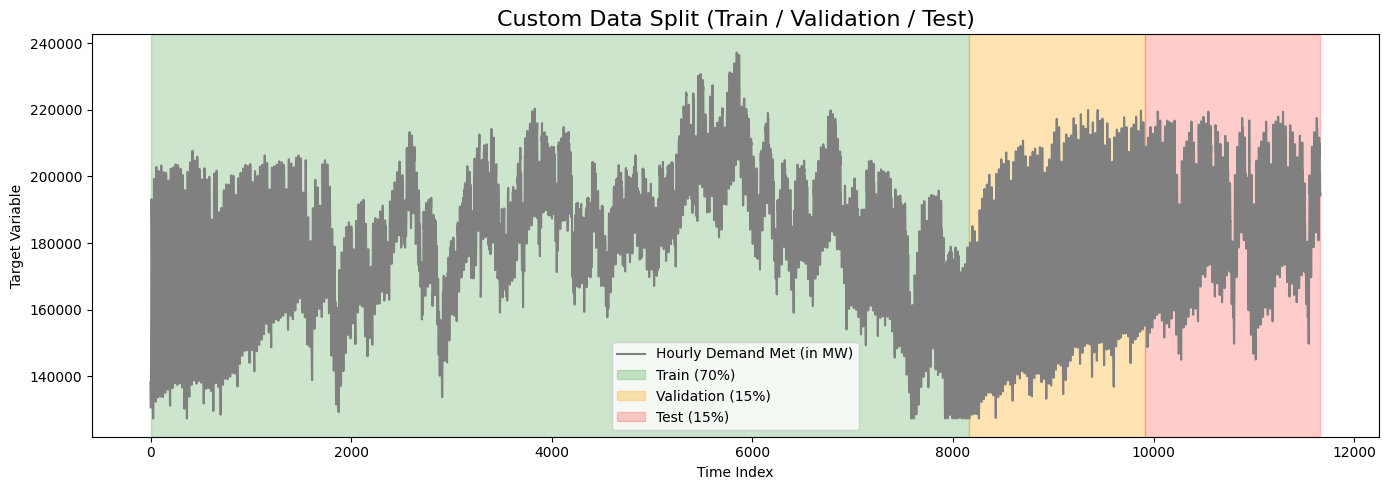

In [9]:
plt.figure(figsize=(14, 5))
plt.plot(y.values, label='Hourly Demand Met (in MW)', color='gray')

plt.axvspan(0, train_end, color='green', alpha=0.2, label='Train (70%)')
plt.axvspan(train_end, val_end, color='orange', alpha=0.3, label='Validation (15%)')
plt.axvspan(val_end, n, color='red', alpha=0.2, label='Test (15%)')

plt.title('Custom Data Split (Train / Validation / Test)', fontsize=16)
plt.xlabel('Time Index')
plt.ylabel('Target Variable')
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# Saving the training, validation and testing splits as CSV files to ensure reproducibility

X_train.to_csv('train_data.csv', index=False)
y_train.to_csv('train_target.csv', index=False)

X_val.to_csv('val_data.csv', index=False)
y_val.to_csv('val_target.csv', index=False)

X_test.to_csv('test_data.csv', index=False)
y_test.to_csv('test_target.csv', index=False)


### <span style="color:crimson;">B. Model Training and Feature Evaluation</span>
#### B.1 Import required libraries

In [11]:
# Importing necessary libraries for XGBoost, evaluation, and plotting
import xgboost as xgb
from   sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

#### B.2 Train the XGBoost Regressor

In [12]:
# Backup datetime column before dropping from features
datetime_train = X_train['datetime'].copy()
datetime_val = X_val['datetime'].copy()
datetime_test = X_test['datetime'].copy()

# Drop from training features
X_train = X_train.drop(columns=['datetime'], errors='ignore')
X_val = X_val.drop(columns=['datetime'], errors='ignore')
X_test = X_test.drop(columns=['datetime'], errors='ignore')


In [9]:
# Initialize XGBoost Regressor model
xg_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=6)

from sklearn.model_selection import cross_val_score

# Perform Cross-validation on the Training Set (70%)
cv_scores = cross_val_score(xg_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation results
print(f"Cross-validation scores (MSE): {cv_scores}")
print(f"Mean Cross-validation score (MSE): {cv_scores.mean()}")

# Fit the model on the training data
xg_model.fit(X_train, y_train)

Cross-validation scores (MSE): [-14470903.68478146  -5303711.7848318   -4222880.1005655
 -14068963.9788728   -8301274.82831232]
Mean Cross-validation score (MSE): -9273546.875472777


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

#### B.3 Evaluate the Model

In [10]:
# Make predictions on the validation data
y_val_pred = xg_model.predict(X_val)

# Compute performance metrics
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

# Print the results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


RMSE: 2414.1935
MAE: 1794.7088
R²: 0.9894


E:\Anaconda3\envs\pycaret-env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### B.4 Visualize Predictions vs. Actual

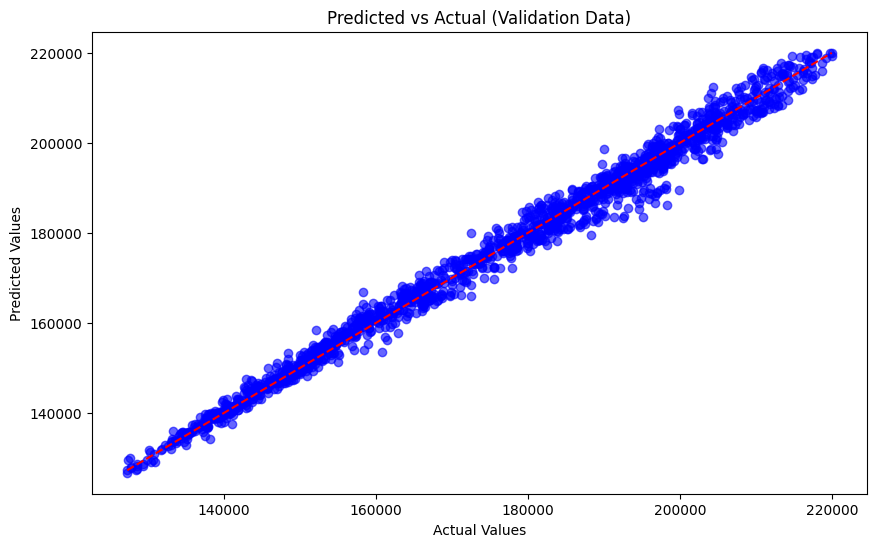

In [11]:
# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, color='blue', alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.title('Predicted vs Actual (Validation Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


#### B.5 Feature Importance Plot

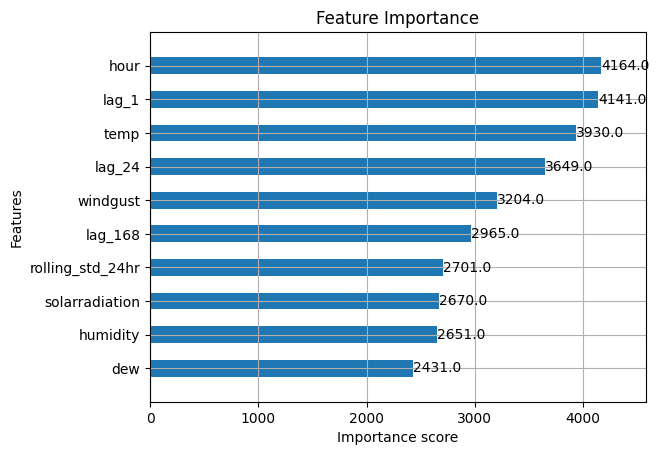

In [12]:
# Plot feature importance
xgb.plot_importance(xg_model, importance_type='weight', max_num_features=10, height=0.5)
plt.title('Feature Importance')
plt.show()

#### B.5 Residual Plot
This plot will help us understand the difference between actual and predicted values for the validation set. We’re looking for any patterns in the residuals that could indicate model bias.

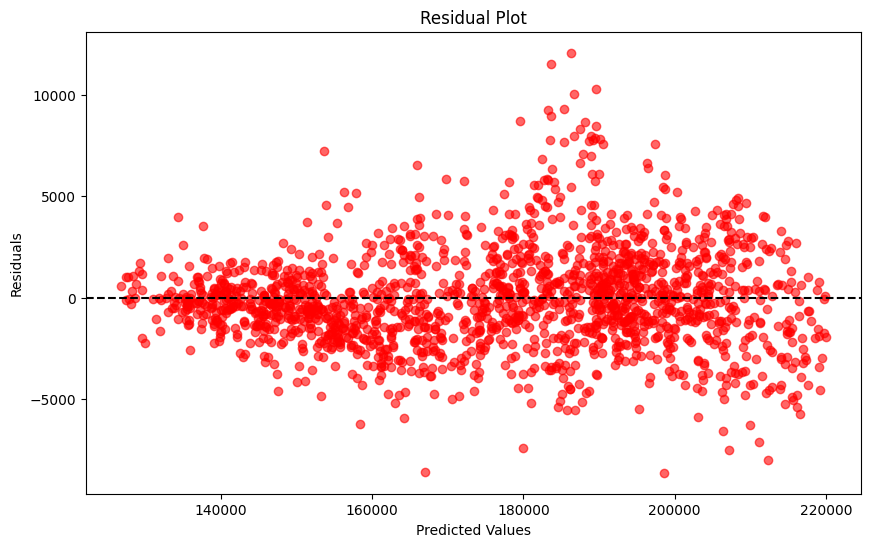

In [13]:
# Residuals Plot
residuals = y_val - y_val_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred, residuals, alpha=0.6, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

#### B.6 Error Distribution Plot
This plot will show the distribution of errors (differences between actual and predicted values). A normal distribution of errors indicates that the model’s predictions are unbiased.

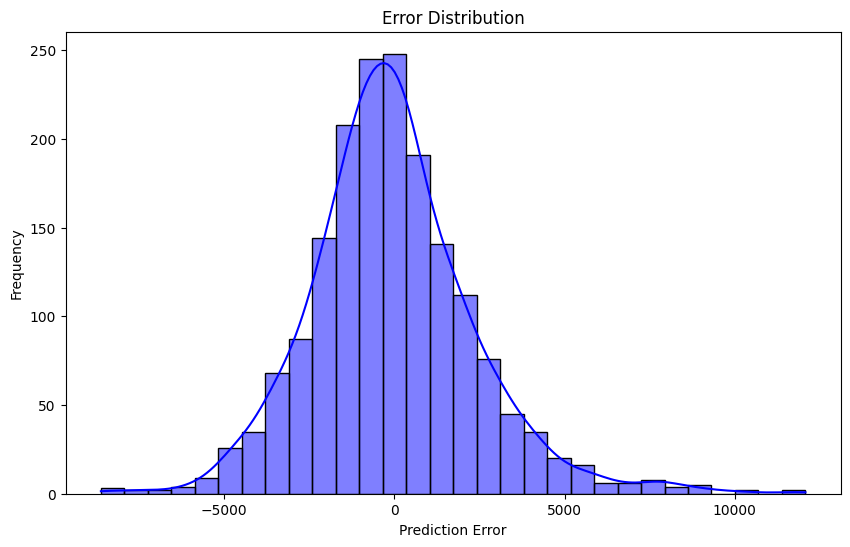

In [13]:
# Error Distribution Plot
errors = y_val - y_val_pred

plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color='blue', bins=30)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


#### B.7 Cumulative Error Over Time
This plot shows how errors accumulate over time, helping us identify if the model performs better at certain times or days.

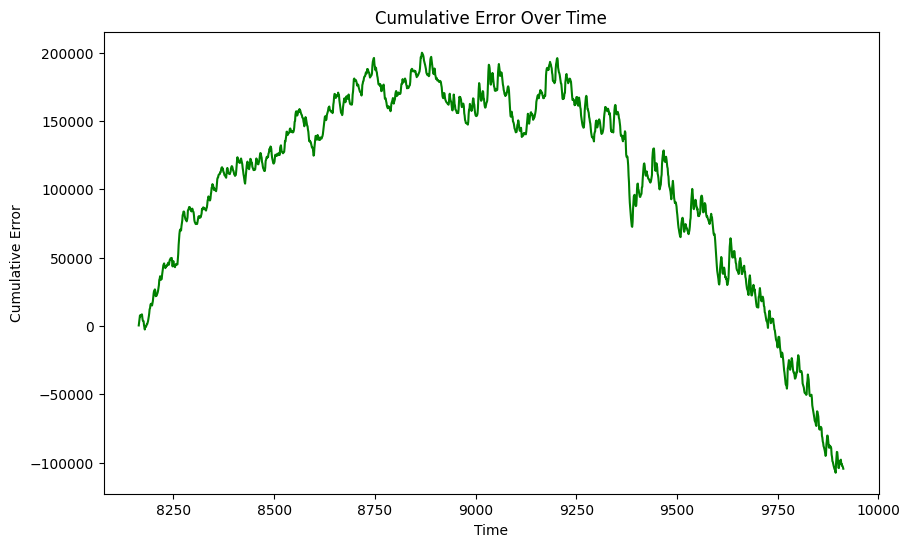

In [14]:
# Cumulative Error Over Time
cumulative_error = errors.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_error, color='green')
plt.title('Cumulative Error Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Error')
plt.show()

#### B.8 SHAP (SHapley Additive exPlanations) feature impact using a beeswarm plot
We'll visualize how each feature contributes to the model's predictions. SHAP values help explain the magnitude and direction of each feature’s impact on the output, making it easier to understand which features are influencing the model's decisions.

In [15]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [16]:
X_train.shape

(8164, 41)

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164 entries, 0 to 8163
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temp               8164 non-null   float64
 1   dew                8164 non-null   float64
 2   humidity           8164 non-null   float64
 3   windgust           8164 non-null   float64
 4   windspeed          8164 non-null   float64
 5   sealevelpressure   8164 non-null   float64
 6   cloudcover         8164 non-null   float64
 7   visibility         8164 non-null   float64
 8   solarradiation     8164 non-null   float64
 9   uvindex            8164 non-null   float64
 10  winddir_sin        8164 non-null   float64
 11  winddir_cos        8164 non-null   float64
 12  hour               8164 non-null   int64  
 13  dayofweek          8164 non-null   int64  
 14  quarter            8164 non-null   int64  
 15  month              8164 non-null   int64  
 16  year               8164 

In [18]:
#SHAP doesn't support bool dtype directly in some backends (like xgboost or tree_explainer). 
#Even though the categorical features are one-hot encoded as bool, we still need to convert them to int (0/1) before passing to SHAP.

# Convert all bool columns to int (0 or 1)
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})
X_val = X_val.astype({col: 'int' for col in X_val.select_dtypes('bool').columns})


100%|===================| 1749/1750 [04:45<00:00]        

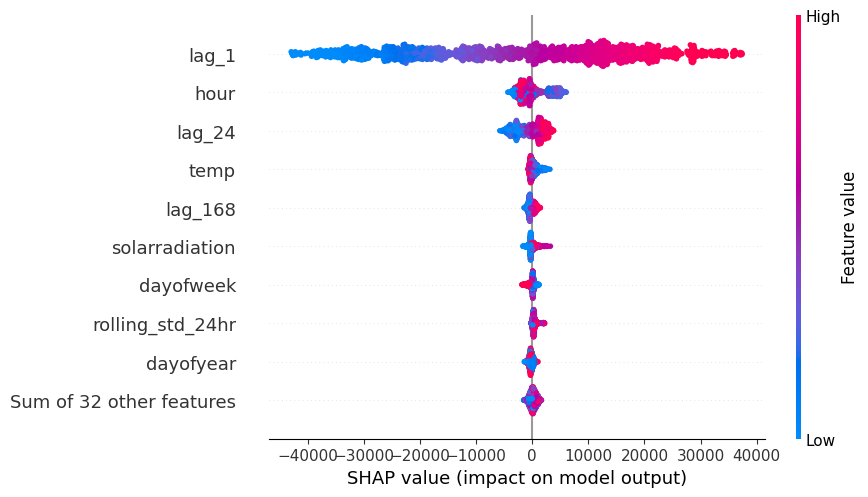

In [19]:
import shap

# Create a SHAP explainer for the trained XGBoost model
explainer = shap.Explainer(xg_model, X_train)

# Calculate SHAP values
shap_values = explainer(X_val)  # Use validation set for feature impact

# Plot the SHAP values as a beeswarm plot
plt.figure(figsize=(12, 6))
shap.plots.beeswarm(shap_values)

To understand how each feature influences the model’s predictions, we use SHAP (SHapley Additive exPlanations) — a powerful tool for model interpretability.

Among various SHAP visualizations, the **Beeswarm plot** stands out for offering a compact, intuitive summary:

- Each point represents a prediction for one sample.
- The position on the x-axis shows impact (SHAP value).
- The color indicates the feature value (e.g., high/low).

### <span style="color:crimson;">C. Temporal Predictions and Insights</span>
#### C.1 First Month Prediction Plot — Actual vs Predicted
Objective: Visualize how well the model performs for a continuous one-month window — this helps in capturing daily and hourly fluctuations.

Here, we:
- Pick the first month from our validation data.
- Plot actual vs predicted values (line chart).
- Add visual flair with Plotly for interactivity. 📈✨

<div style="background-color: #f5f0ff; padding: 18px; border-left: 6px solid #6c5ce7; border-radius: 10px;">

#### When Do We Use the Test Set?

During the model development process, we **do not touch the test set** until we've completed model selection and hyperparameter tuning. Here's how we structure the workflow:

#### ⚙️ Current Phase:
- ✅ **Training Set** → Used to train the model
- ✅ **Validation Set** → Used to evaluate and fine-tune model hyperparameters

#### 🚀 Final Phase (After Tuning):
- Combine **Training + Validation** → Retrain final model on **85% of data.**
- **Test Set (15%)** → Used **only once** for final performance evaluation.

This approach ensures that the test results reflect **true generalization performance** — just like real-world unseen data.

</div>


In [20]:
# Convert datetime_valid to datetime type if it's in string format
datetime_val = pd.to_datetime(datetime_val)

# Reassign proper datetime index to y_val
y_val = pd.Series(y_val.values, index=datetime_val)


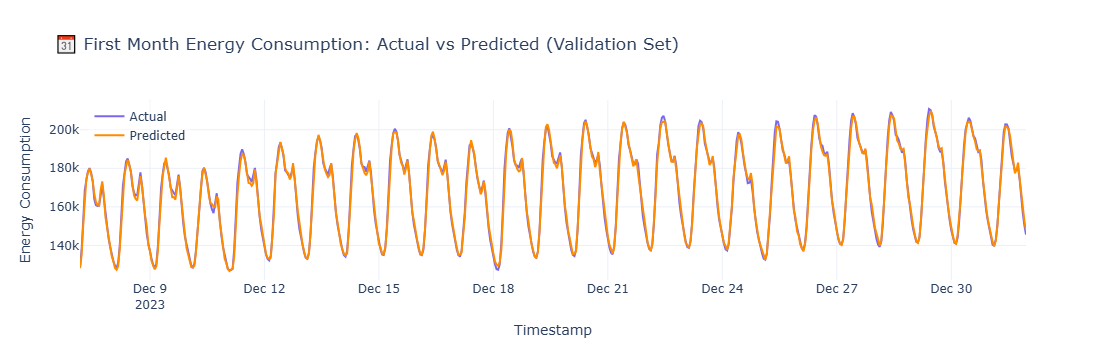

In [21]:
import plotly.graph_objects as go
import pandas as pd

# Ensure y_val has a datetime index (replace datetime_val accordingly)
y_val = pd.Series(y_val.values, index=datetime_val)

# Select the first month from the datetime index
first_month = y_val.index[0].month
first_month_mask = y_val.index.month == first_month

# Filter actual and predicted values for the first month
first_month_data = y_val[first_month_mask]
first_month_preds = y_val_pred[first_month_mask]

# Create interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=first_month_data.index, y=first_month_data,
                         mode='lines', name='Actual', line=dict(color='mediumslateblue')))
fig.add_trace(go.Scatter(x=first_month_data.index, y=first_month_preds,
                         mode='lines', name='Predicted', line=dict(color='darkorange')))

fig.update_layout(title="📆 First Month Energy Consumption: Actual vs Predicted (Validation Set)",
                  xaxis_title="Timestamp",
                  yaxis_title="Energy Consumption",
                  template="plotly_white",
                  legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.5)'))

fig.show()


#### C.2 First Week of a Random Month – Actual vs Predicted (Zoomed View)

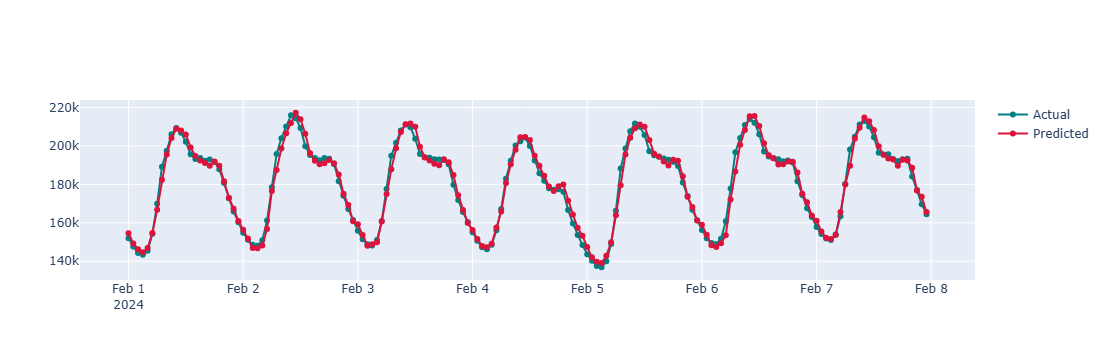

In [22]:
import numpy as np
import plotly.graph_objects as go

# Ensure datetime index is set
y_val = pd.Series(y_val.values, index=datetime_val)
y_pred_val_series = pd.Series(y_val_pred, index=datetime_val)

# Pick a random month from validation set
random_month = np.random.choice(y_val.index.month.unique())

# Filter for the selected month
month_mask = y_val.index.month == random_month
month_data = y_val[month_mask]
month_preds = y_pred_val_series[month_mask]

# Get the first 7 days of that month
first_week_dates = month_data.index.normalize().unique()[:7]
week_mask = month_data.index.normalize().isin(first_week_dates)
week_actual = month_data[week_mask]
week_preds = month_preds[week_mask]

# Create zoomed line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=week_actual.index, y=week_actual,
                         mode='lines+markers', name='Actual', line=dict(color='teal')))
fig.add_trace(go.Scatter(x=week_actual.index, y=week_preds,
                         mode='lines+markers', name='Predicted', line=dict(color='crimson')))

fig


#### C.3 Best Predicted Days (Lowest Error)

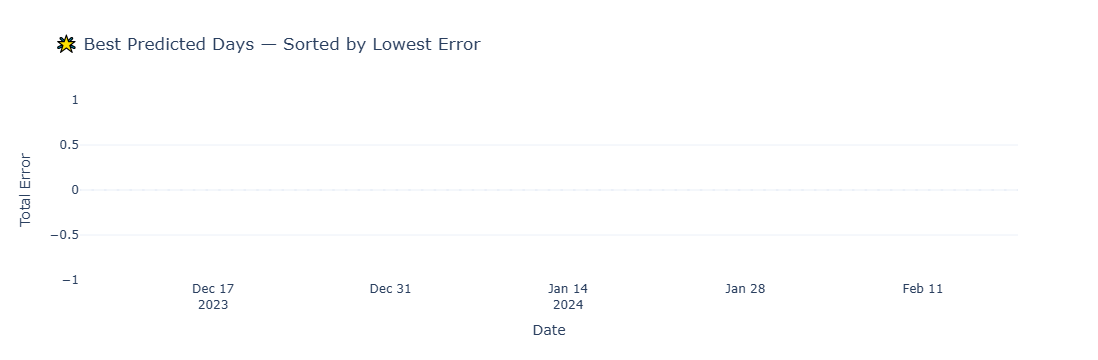

In [23]:
import plotly.graph_objects as go

# Calculate error between actual and predicted values
error = abs(y_val - y_val_pred)

# Create a DataFrame with date and error
error_df = pd.DataFrame({
    'datetime': datetime_val,
    'error': error
})

# Group by day and sum the error for each day
error_df['date'] = error_df['datetime'].dt.date
daily_error = error_df.groupby('date')['error'].sum().sort_values(ascending=True)

# Plot the best predicted days
fig = go.Figure()

fig.add_trace(go.Bar(x=daily_error.index, y=daily_error.values, name='Error',
                     marker=dict(color='green')))

fig.update_layout(title="🌟 Best Predicted Days — Sorted by Lowest Error",
                  xaxis_title="Date",
                  yaxis_title="Total Error",
                  template="plotly_white")

fig.show()


#### C.4 Worst Predicted Days (Highest Error)

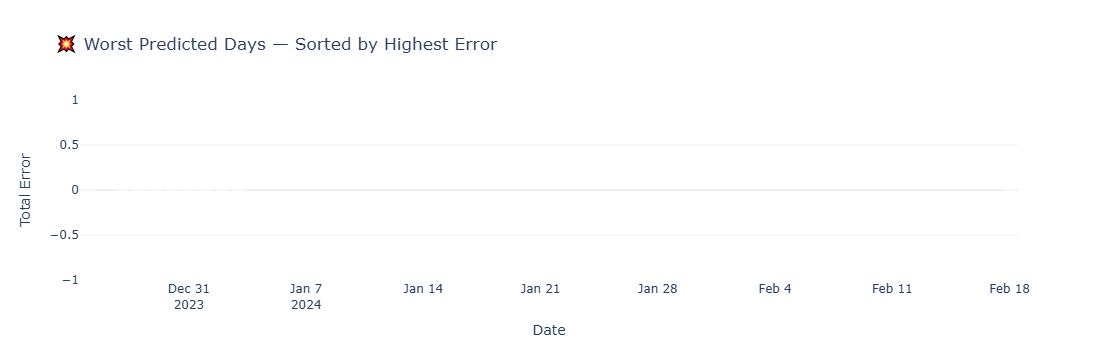

In [24]:
# Select the worst predicted days (highest error)
worst_predicted_days = daily_error.tail(10)  # Top 10 worst predicted days

# Plot the worst predicted days
fig = go.Figure()

fig.add_trace(go.Bar(x=worst_predicted_days.index, y=worst_predicted_days.values, name='Worst Predicted Days',
                     marker=dict(color='red')))

fig.update_layout(title="💥 Worst Predicted Days — Sorted by Highest Error",
                  xaxis_title="Date",
                  yaxis_title="Total Error",
                  template="plotly_white")

fig.show()


#### C.6 Overall Actual vs Predicted.

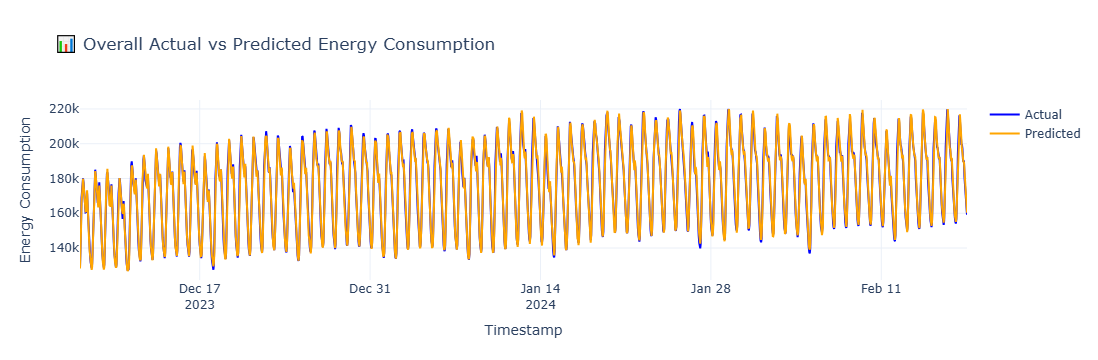

In [25]:
import plotly.graph_objects as go

# Create an interactive line plot for actual vs predicted
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=datetime_val, y=y_val,
                         mode='lines', name='Actual', line=dict(color='blue')))

# Plot predicted values
fig.add_trace(go.Scatter(x=datetime_val, y=y_val_pred,
                         mode='lines', name='Predicted', line=dict(color='orange')))

fig.update_layout(title="📊 Overall Actual vs Predicted Energy Consumption",
                  xaxis_title="Timestamp",
                  yaxis_title="Energy Consumption",
                  template="plotly_white")

fig.show()


#### C.7 Temporal Drift Plot
This plot will show the trend of error (e.g., Mean Absolute Error, MAE) over time. This helps us understand how the prediction error varies across different months, revealing any patterns or potential drift in model performance.

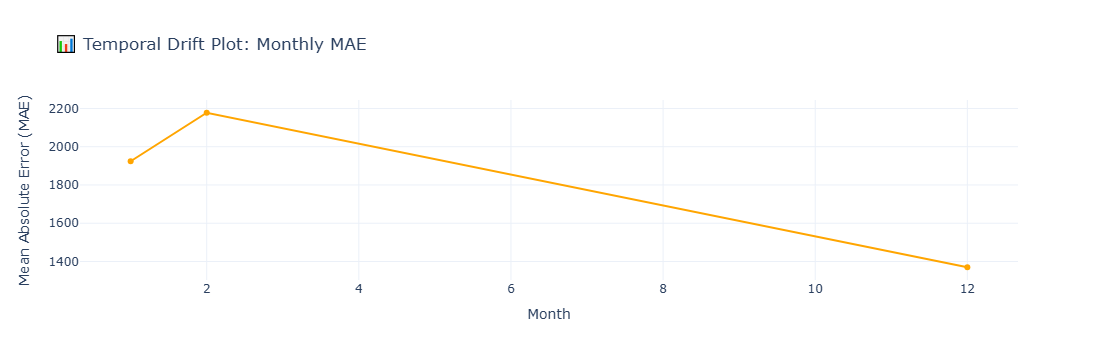

In [27]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error

# Calculate the MAE for each month
mae_per_month = []

# Iterate over each month to calculate MAE
for month in range(1, 13):  # For each month (1-12)
    # Filter the validation set for the specific month
    month_data = y_val[y_val.index.month == month]
    month_preds = y_val_pred[y_val.index.month == month]
    
    # Check if both actual and predicted values are not empty for the month
    if len(month_data) > 0 and len(month_preds) > 0:
        # Calculate MAE for that month
        mae = mean_absolute_error(month_data, month_preds)
        mae_per_month.append(mae)
    else:
        # If no data for the month, append None (or you can skip the month if you prefer)
        mae_per_month.append(None)

# Prepare a DataFrame with months and MAE values
mae_df = pd.DataFrame({'Month': range(1, 13), 'MAE': mae_per_month})

# Drop months where MAE is None (optional, if you want to avoid plotting missing values)
mae_df = mae_df.dropna()

# Plot the Temporal Drift Plot (Monthly MAE)
fig = go.Figure()

fig.add_trace(go.Scatter(x=mae_df['Month'], y=mae_df['MAE'],
                         mode='lines+markers', name='MAE',
                         line=dict(color='orange', width=2)))

fig.update_layout(title="📊 Temporal Drift Plot: Monthly MAE",
                  xaxis_title="Month",
                  yaxis_title="Mean Absolute Error (MAE)",
                  template="plotly_white")

fig.show()


#### C.8 Actual vs Predicted Heatmap
This visualization will help us understand how the predictions align with the actual values over time, particularly focusing on how the energy consumption varies by the hour of the day and the day of the month. This is useful for identifying patterns, anomalies, and areas where predictions could be improved.

We’ll create a heatmap with the following steps:
- Plot the actual vs predicted values.
- Show the heatmap for hour of the day vs day of the month, using the mean values of actual and predicted energy consumption.

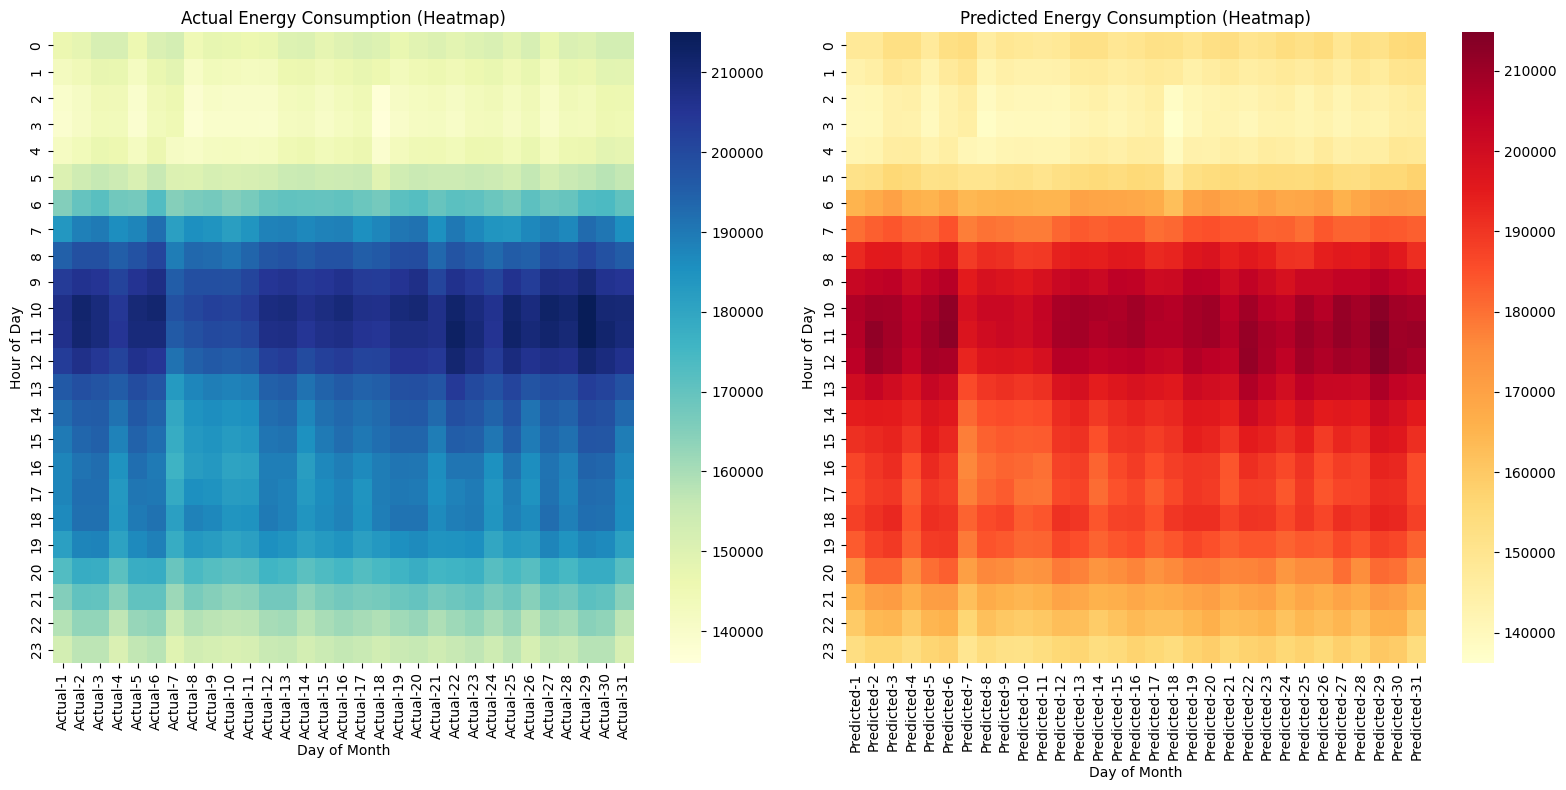

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure that datetime index is available and corresponds to the validation set
# Create DataFrames for actual and predicted values
actual_df = y_val.to_frame(name='Actual')
predicted_df = pd.DataFrame(y_val_pred, index=y_val.index, columns=['Predicted'])

# Extract the hour and day of month for both actual and predicted data
actual_df['Hour'] = actual_df.index.hour
actual_df['Day'] = actual_df.index.day
predicted_df['Hour'] = predicted_df.index.hour
predicted_df['Day'] = predicted_df.index.day

# Calculate mean values of actual and predicted for each combination of hour and day
actual_heatmap = actual_df.groupby(['Hour', 'Day']).mean().unstack(fill_value=0)
predicted_heatmap = predicted_df.groupby(['Hour', 'Day']).mean().unstack(fill_value=0)

# Plot heatmap for Actual vs Predicted comparison
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(actual_heatmap, annot=False, cmap="YlGnBu", ax=ax[0])
ax[0].set_title('Actual Energy Consumption (Heatmap)')
ax[0].set_xlabel('Day of Month')
ax[0].set_ylabel('Hour of Day')

sns.heatmap(predicted_heatmap, annot=False, cmap="YlOrRd", ax=ax[1])
ax[1].set_title('Predicted Energy Consumption (Heatmap)')
ax[1].set_xlabel('Day of Month')
ax[1].set_ylabel('Hour of Day')

plt.tight_layout()
plt.show()


### <span style="color:crimson;">D. Hyperparameter Tuning</span>
We'll perform hyperparameter tuning for the XGBoost model using grid search or randomized search to find the best combination of hyperparameters. This will help in optimizing the model's performance.

**Steps for Hyperparameter Tuning:**

1. Choose hyperparameters to tune:
- Learning rate (learning_rate)
- Number of estimators (n_estimators)
- Max depth (max_depth)
- Subsample (subsample)
- Colsample_bytree (colsample_bytree)

2. Use GridSearchCV or RandomizedSearchCV: We'll use `GridSearchCV` or `RandomizedSearchCV` from `sklearn` to search for the best hyperparameter values.


#### D.1 Model Hyperparameter Tuning (Grid Search)

In [29]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the model
xgb_model = XGBRegressor(objective='reg:squarederror')

# Set the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [500, 1000, 1500],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Use the best model for prediction
best_model = grid_search.best_estimator_

# Fit on full training data
best_model.fit(X_train, y_train)

# Predictions on the validation set
y_pred_val = best_model.predict(X_val)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9; total time=  11.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9; total time=   8.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=1.0; total time=   8.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=1.0; total time=   7.5s
[CV] END

#### D.2 Analyzing Learning Rate vs. Error (RMSE)

Although we have already completed hyperparameter tuning and selected the optimal learning rate, this plot provides **additional insight** into how different learning rates impact model performance.

**Why do we include this plot?**
- It helps **visualize the sensitivity** of the model to the learning rate (`eta`).
- Demonstrates the trade-off between **training speed** and **model accuracy**.
- Reinforces confidence in the **chosen learning rate** by showing its comparative performance.

**Interpretation**:
- The **validation RMSE curve** shows how generalization error changes with different learning rates.
- A **minimum point** in the curve indicates the most effective learning rate.

Even though tuning is complete, this plot adds valuable transparency and visual explanation to the model development process.


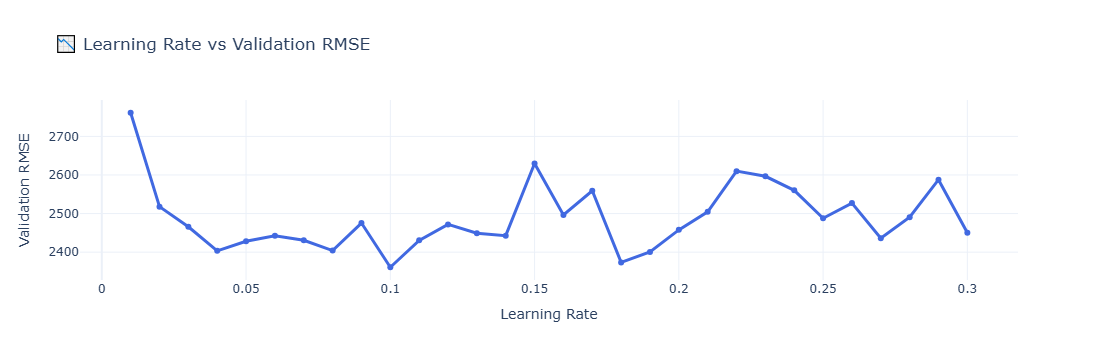

In [30]:
import numpy as np
import plotly.express as px
from sklearn.metrics import mean_squared_error

# Define a range of learning rates to try
learning_rates = np.linspace(0.01, 0.3, 30)

rmse_list = []

# Train a model for each learning rate
for lr in learning_rates:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=lr,
        n_estimators=500,
        max_depth=6,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    rmse_list.append(rmse)

# Create DataFrame for plotting
lr_df = pd.DataFrame({'Learning Rate': learning_rates, 'Validation RMSE': rmse_list})

# Plot using Plotly
fig = px.line(
    lr_df, x='Learning Rate', y='Validation RMSE',
    title='📉 Learning Rate vs Validation RMSE',
    markers=True,
    template='plotly_white'
)
fig.update_traces(line=dict(color='royalblue', width=3))
fig.update_layout(
    xaxis_title='Learning Rate',
    yaxis_title='Validation RMSE'
)
fig.show()


#### D.3 Model Performance with Best Hyperparameters: Actual vs Predicted Energy Consumption

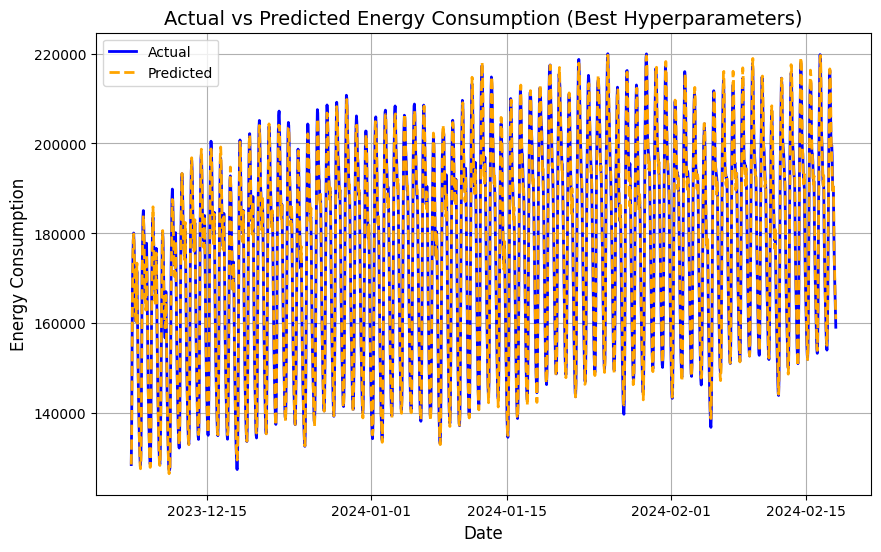

RMSE with best hyperparameters: 2397.021556364168


In [31]:
# Extract the best parameters from GridSearchCV result
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.01,
    'max_depth': 6,
    'n_estimators': 1500,
    'subsample': 0.8
}

# Train the model with the best parameters
best_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    **best_params
)

# Fit the model on the training data
best_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_best = best_model.predict(X_val)

# Compute RMSE on the validation set
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_best = np.sqrt(mean_squared_error(y_val, y_val_pred_best))

# Plotting the RMSE as performance on the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_val.index, y_val, label='Actual', color='blue', linewidth=2)
plt.plot(y_val.index, y_val_pred_best, label='Predicted', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Energy Consumption (Best Hyperparameters)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Consumption', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Display RMSE
print(f"RMSE with best hyperparameters: {rmse_best}")


#### D.4 Refined Learning Rate Search

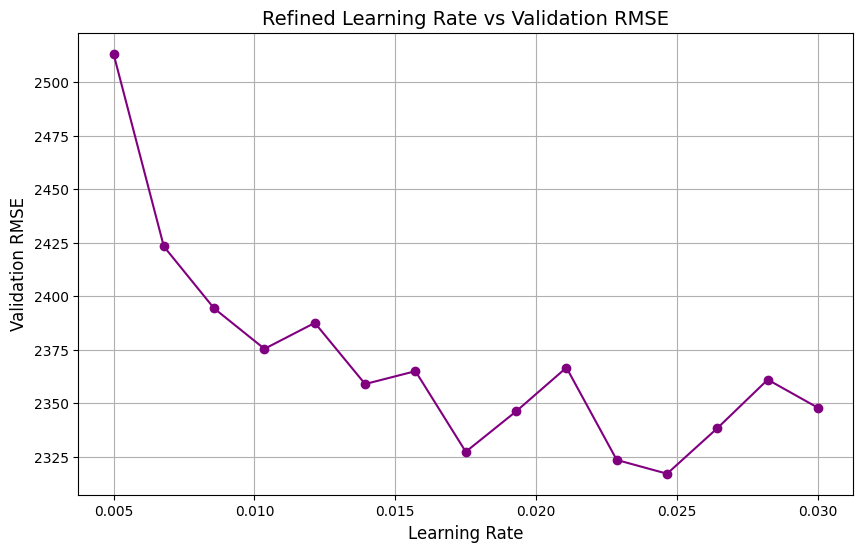

Best learning rate from refined search: 0.0246 with RMSE = 2316.9662


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Best params (from tuning)
fixed_params = {
    'max_depth': 6,
    'n_estimators': 1500,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Refined range of learning rates
refined_lrs = np.linspace(0.005, 0.03, 15)
val_rmse_list = []

for lr in refined_lrs:
    model = XGBRegressor(learning_rate=lr, **fixed_params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    val_rmse_list.append(rmse)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(refined_lrs, val_rmse_list, marker='o', color='purple')
plt.title("Refined Learning Rate vs Validation RMSE", fontsize=14)
plt.xlabel("Learning Rate", fontsize=12)
plt.ylabel("Validation RMSE", fontsize=12)
plt.grid(True)
plt.show()

# Best LR
best_lr_idx = np.argmin(val_rmse_list)
best_lr = refined_lrs[best_lr_idx]
print(f"Best learning rate from refined search: {best_lr:.4f} with RMSE = {val_rmse_list[best_lr_idx]:.4f}")


#### D.5 Final Model with Refined Learning Rate

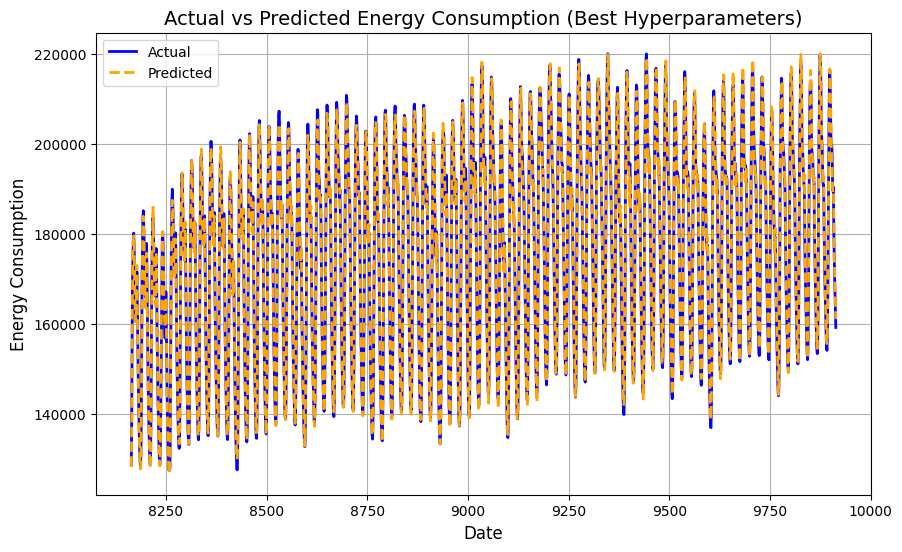

RMSE with best hyperparameters: 2351.5689933187964


In [13]:
# Importing Necessary libraries again
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.0246,
    'max_depth': 6,
    'n_estimators': 1500,
    'subsample': 0.8
}

# Train the model with the best parameters
best_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    **best_params
)

# Fit the model on the training data
best_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_best = best_model.predict(X_val)

# Compute RMSE on the validation set
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_best = np.sqrt(mean_squared_error(y_val, y_val_pred_best))

# Plotting the RMSE as performance on the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_val.index, y_val, label='Actual', color='blue', linewidth=2)
plt.plot(y_val.index, y_val_pred_best, label='Predicted', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Energy Consumption (Best Hyperparameters)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Consumption', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Display RMSE
print(f"RMSE with best hyperparameters: {rmse_best}")


#### D.6 Visualizing Hyperparameter Impact
#### D.6.1 Plotting maxDepth vs. RMSE

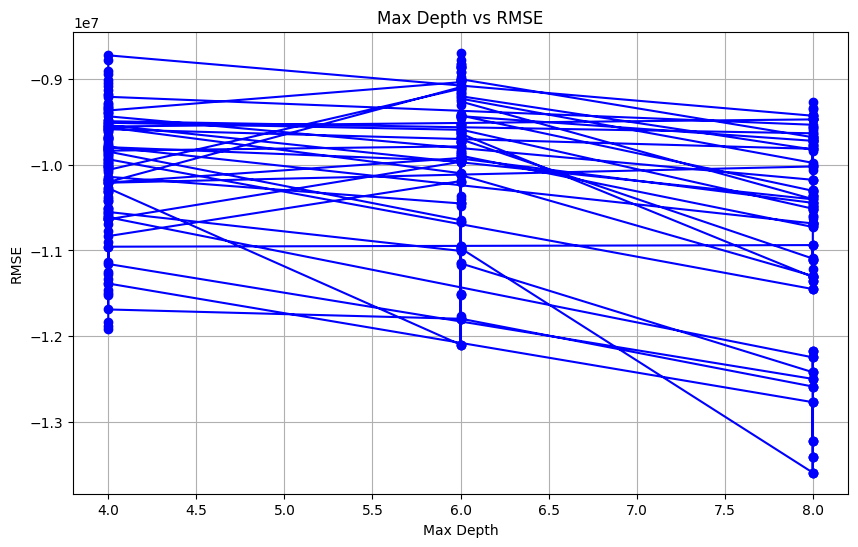

In [35]:
import pandas as pd
grid_results = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10, 6))
plt.plot(grid_results['param_max_depth'], grid_results['mean_test_score'], marker='o', color='b')
plt.title('Max Depth vs RMSE')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

#### D.6.2 Plotting n_estimators vs. RMSE

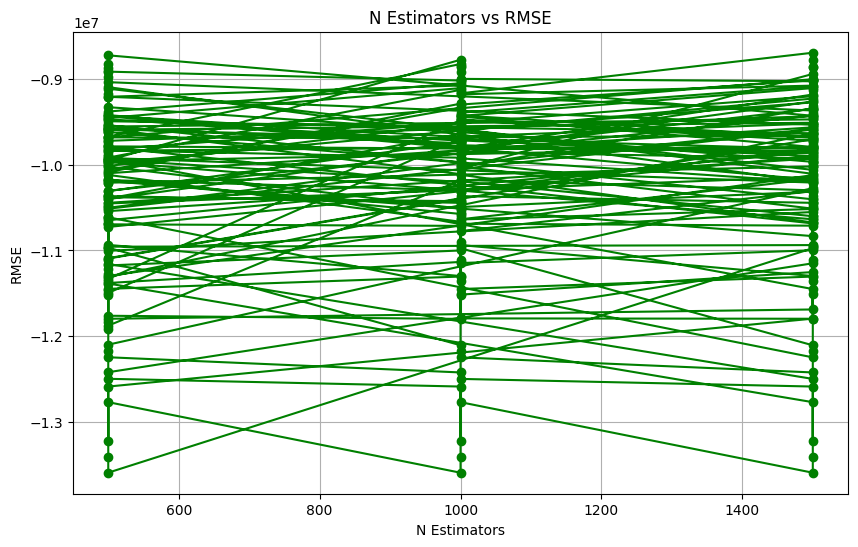

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(grid_results['param_n_estimators'], grid_results['mean_test_score'], marker='o', color='g')
plt.title('N Estimators vs RMSE')
plt.xlabel('N Estimators')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


These graphs illustrate the results of hyperparameter tuning for our regression model:

- **The first graph** shows how the model’s prediction error (measured as RMSE-Root Mean Squared Error) changes as we adjust the `max_depth` parameter, which controls the maximum depth of each tree in the model.
- **The second graph** shows how RMSE changes with different values of `n_estimators`, which is the number of trees used in the ensemble.

In each graph:
- **Each line represents a different run or parameter combination during cross-validation.**
- **The y-axis (RMSE) is negative** because scikit-learn’s hyperparameter search uses negative RMSE for optimization (lower RMSE is better).
- **The x-axis** shows the tested values for `max_depth` or `n_estimators`.

**What we observe:**  
- The RMSE values do not change dramatically as we increase `max_depth` or `n_estimators` within the tested range, suggesting the model’s performance is stable and not highly sensitive to these parameters.
- This helps us select values (like `max_depth=6` and `n_estimators=1500`) that balance performance and complexity, avoiding overfitting or unnecessarily long training times.

**In summary:**  
These plots helped us visualize and choose the best hyperparameters for our model by showing how prediction error responds to changes in tree depth and the number of trees.

### <span style="color:crimson;">E. FINAL EVALUATION: Test Set Evaluation</span>

<div style="font-weight:600; line-height:1.6px;">
    
After training and hyperparameter tuning, we evaluate the model's performance on the test set to ensure it generalizes well to unseen data.
</div>

#### E.1 Prediction on the Test Set
We use the best model that was trained on the training data and validated on the validation set to make predictions on the test set.


In [14]:
# Make predictions on the test set using the best model
y_test_pred = best_model.predict(X_test)


#### E.2 Evaluation Metrics

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Compute RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Compute MAE
mae_test = mean_absolute_error(y_test, y_test_pred)

# Compute R² score
r2_test = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test R²: {r2_test}")


Test RMSE: 2815.2927042869837
Test MAE: 2125.120217857143
Test R²: 0.9725298810054837


#### E.3 Visualizing Actual vs. Predicted for the Test Set

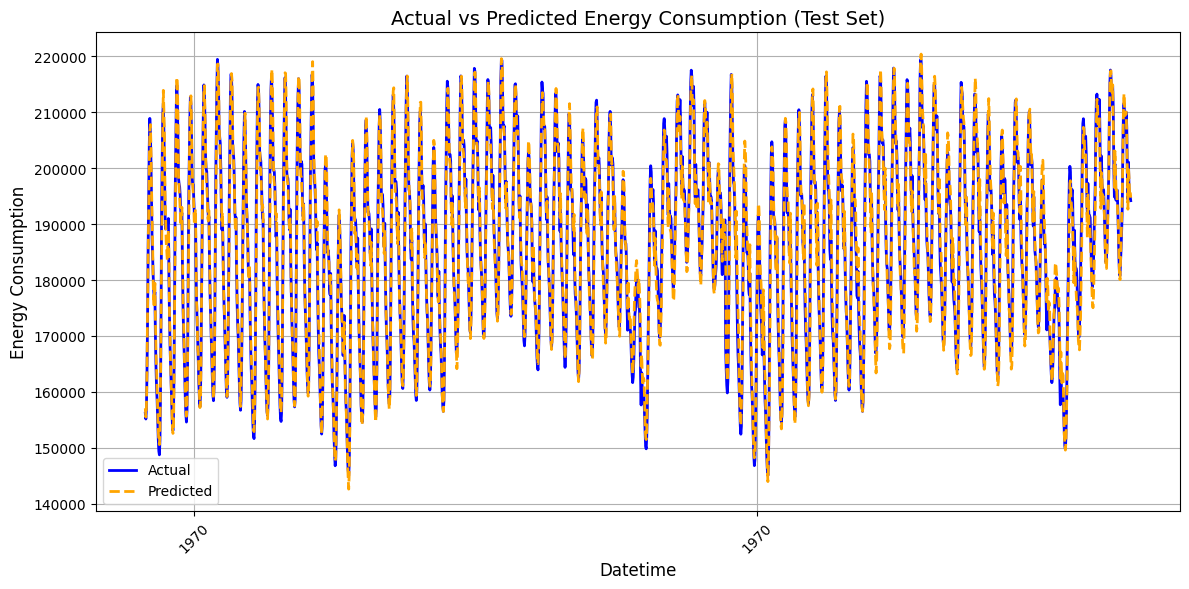

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure index is in datetime format
y_test.index = pd.to_datetime(y_test.index)

# Plot Actual vs Predicted for the Test Set
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linewidth=2)
plt.plot(y_test.index, y_test_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Energy Consumption (Test Set)', fontsize=14)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Energy Consumption', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### E.4 Additional Plots

<div style="font-size: 15px;">
    
- **Residuals Plot**: Visualizes the error between the actual and predicted values.
- **Error Distribution Plot**: Displays the distribution of residuals to evaluate if errors are normally distributed.

</div>

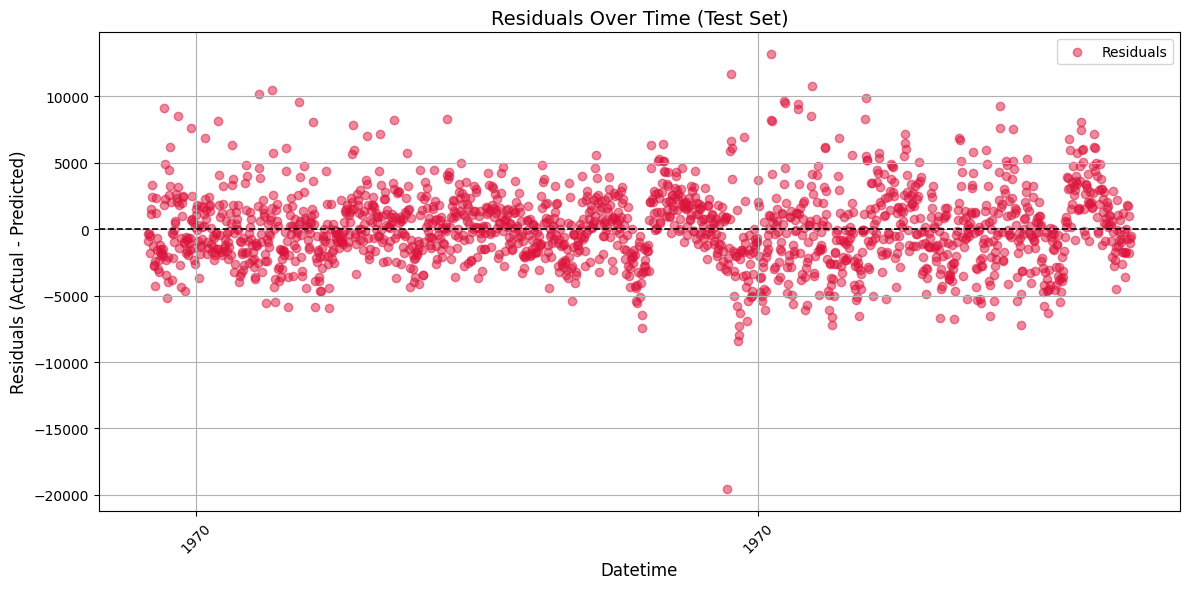

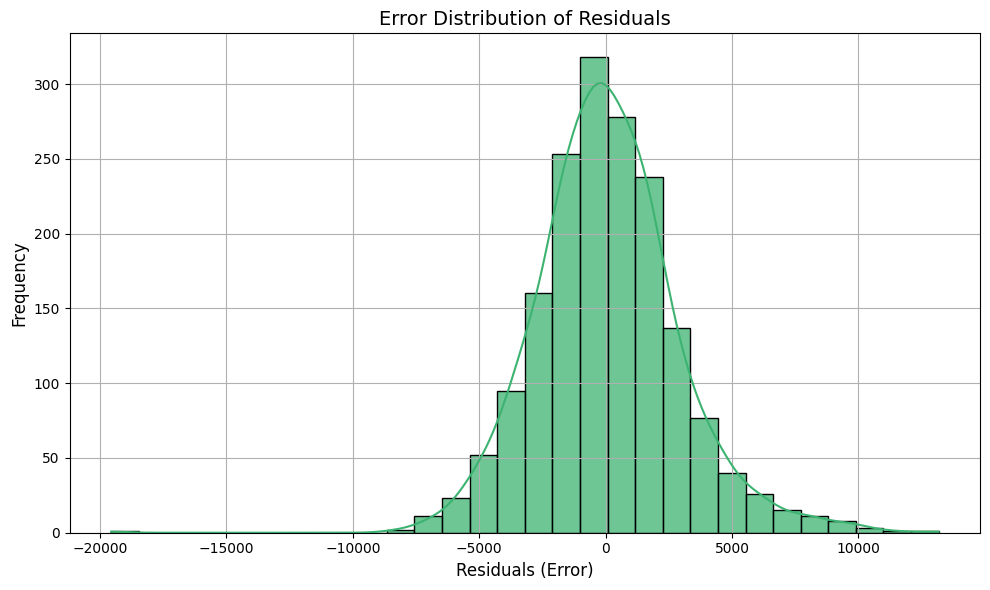

In [17]:
# Residuals Calculation
residuals = y_test - y_test_pred

# Ensure datetime index
y_test.index = pd.to_datetime(y_test.index)

# Residuals Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test.index, residuals, color='crimson', alpha=0.5, label='Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1.2)
plt.title('Residuals Over Time (Test Set)', fontsize=14)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

import seaborn as sns

# Error Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='mediumseagreen', edgecolor='black', alpha=0.75)
plt.title('Error Distribution of Residuals', fontsize=14)
plt.xlabel('Residuals (Error)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
print(y_test.index)


DatetimeIndex(['1970-01-01 00:00:00.000009914',
               '1970-01-01 00:00:00.000009915',
               '1970-01-01 00:00:00.000009916',
               '1970-01-01 00:00:00.000009917',
               '1970-01-01 00:00:00.000009918',
               '1970-01-01 00:00:00.000009919',
               '1970-01-01 00:00:00.000009920',
               '1970-01-01 00:00:00.000009921',
               '1970-01-01 00:00:00.000009922',
               '1970-01-01 00:00:00.000009923',
               ...
               '1970-01-01 00:00:00.000011654',
               '1970-01-01 00:00:00.000011655',
               '1970-01-01 00:00:00.000011656',
               '1970-01-01 00:00:00.000011657',
               '1970-01-01 00:00:00.000011658',
               '1970-01-01 00:00:00.000011659',
               '1970-01-01 00:00:00.000011660',
               '1970-01-01 00:00:00.000011661',
               '1970-01-01 00:00:00.000011662',
               '1970-01-01 00:00:00.000011663'],
              dtype=

In [19]:
y_test.index = datetime_test


In [20]:
print(y_test.index)
print(df['datetime'].iloc[-len(y_test):].head())  # replace 'datetime' with correct column name


Index(['2024-02-18 02:00:00', '2024-02-18 03:00:00', '2024-02-18 04:00:00',
       '2024-02-18 05:00:00', '2024-02-18 06:00:00', '2024-02-18 07:00:00',
       '2024-02-18 08:00:00', '2024-02-18 09:00:00', '2024-02-18 10:00:00',
       '2024-02-18 11:00:00',
       ...
       '2024-04-30 14:00:00', '2024-04-30 15:00:00', '2024-04-30 16:00:00',
       '2024-04-30 17:00:00', '2024-04-30 18:00:00', '2024-04-30 19:00:00',
       '2024-04-30 20:00:00', '2024-04-30 21:00:00', '2024-04-30 22:00:00',
       '2024-04-30 23:00:00'],
      dtype='object', name='datetime', length=1750)
9914    2024-02-18 02:00:00
9915    2024-02-18 03:00:00
9916    2024-02-18 04:00:00
9917    2024-02-18 05:00:00
9918    2024-02-18 06:00:00
Name: datetime, dtype: object


#### Saving the Model

In [21]:
import joblib

# Saving the trained XGBoost model
joblib.dump(best_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

#### Bayesian Optimization for Hyperparameter Tuning (Exploratory)
Objective: To explore whether further performance improvement is achievable beyond manual/grid-based hyperparameter tuning using probabilistic search via Bayesian Optimization.

In [22]:
import joblib

# Load the pre-trained model
model = joblib.load("xgboost_model.pkl")

In [3]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.Collecting bayesian-optimization



In [23]:
import pandas as pd

# Load features
train_data = pd.read_csv("train_data.csv")
val_data = pd.read_csv("val_data.csv")
test_data = pd.read_csv("test_data.csv")

# Load targets
train_target = pd.read_csv("train_target.csv").squeeze()
val_target = pd.read_csv("val_target.csv").squeeze()
test_target = pd.read_csv("test_target.csv").squeeze()

# Drop 'datetime' if present
for df in [train_data, val_data, test_data]:
    if 'datetime' in df.columns:
        df.drop('datetime', axis=1, inplace=True)


In [24]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def xgb_evaluate(learning_rate, max_depth, n_estimators):
    model = xgb.XGBRegressor(
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(train_data, train_target)
    predictions = model.predict(val_data)
    rmse = np.sqrt(mean_squared_error(val_target, predictions))
    
    return -rmse


In [25]:
param_bounds = {
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'n_estimators': (50, 250)
}

optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=param_bounds,
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=20)

print("Best Parameters Found:")
print(optimizer.max)


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | -2.78e+03 | 0.1186    | 9.655     | 196.4     |
| 2         | -2.348e+0 | 0.1836    | 4.092     | 81.2      |
| 3         | -2.851e+0 | 0.02684   | 9.063     | 170.2     |
| 4         | -2.132e+0 | 0.2153    | 3.144     | 244.0     |
| 5         | -2.267e+0 | 0.2514    | 4.486     | 86.36     |
| 6         | -2.881e+0 | 0.03753   | 9.992     | 115.3     |
| 7         | -2.639e+0 | 0.06862   | 9.67      | 230.6     |
| 8         | -2.713e+0 | 0.09992   | 9.923     | 250.0     |
| 9         | -2.466e+0 | 0.08688   | 3.099     | 239.7     |
| 10        | -2.384e+0 | 0.09704   | 3.072     | 246.9     |
| 11        | -2.581e+0 | 0.2581    | 6.133     | 243.3     |
| 12        | -2.257e+0 | 0.2413    | 5.965     | 84.0      |
| 13        | -2.846e+0 | 0.2845    | 8.301     | 87.46     |
| 14        | -2.881e+0 | 0.1072    | 3.303     | 84.39     |
| 15    

In [26]:
best_params = optimizer.max['params']

final_model = xgb.XGBRegressor(
    learning_rate=float(best_params['learning_rate']),
    max_depth=int(best_params['max_depth']),
    n_estimators=int(best_params['n_estimators']),
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

final_model.fit(train_data, train_target)
y_pred = final_model.predict(test_data)

# Evaluation
mae = mean_absolute_error(test_target, y_pred)
rmse = np.sqrt(mean_squared_error(test_target, y_pred))
r2 = r2_score(test_target, y_pred)

print("\n📊 Final Model Evaluation on Test Set:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


📊 Final Model Evaluation on Test Set:
MAE: 2188.3548
RMSE: 2915.5341
R² Score: 0.9705


#### "Bayesian Optimization was performed to validate the scope for further tuning. However, the manually optimized model retained superior performance, indicating proximity to global optima."